# <h1><center> CV7. Stereo image rectification (calibrated camera) </center></h1>

Bài này các bạn sẽ thực hiện rectify cho ảnh thu nhận trên hệ thống stereo với trường hợp tham số trong của mỗi camera có thể được xác nhận (tức là calibrated camera).
- Bước 1: cần xác định các thông số camera dựa trên ảnh bàn cờ thu được từ hệ thống stereo
- Bước 2: Tìm các tham số cho hệ thống stereo: ma trận E, F
- Bước 3: Tìm các tham số cần thiết cho việc thực hiện rectify: ma trận quay cho mỗi ảnh
- Bước 4: Thực hiện rectify cho các cặp ảnh
- Tính disparity từ cặp ảnh

<h1><center> B1: Individual calibration of the right and left cameras of the stereo setup</center></h1>

In [1]:
# Các thư viện cần thiết
import os
import numpy as np 
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Dữ liệu dùng cho calibrate camera
# Set the path to the images captured by the left and right cameras
pathL = "data/stereoL/"
pathR = "data/stereoR/"

In [3]:
# Termination criteria for refining the detected corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [4]:
# Chuẩn bị object points giống như: (0,0,0), (1,0,0), ...., (10,6,0)
# Kích thước ô bàn cờ: 10x7
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

img_ptsL = []
img_ptsR = []
obj_pts = []

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.72it/s]


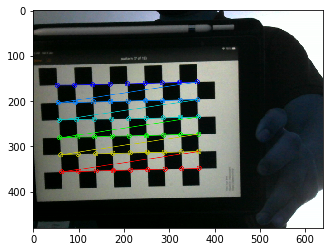

In [5]:
for i in tqdm(range(1,28)):
    imgL = cv2.imread(pathL+"img%d.png"%i)
    imgR = cv2.imread(pathR+"img%d.png"%i)
    imgL_gray = cv2.imread(pathL+"img%d.png"%i,0)
    imgR_gray = cv2.imread(pathR+"img%d.png"%i,0)

    outputL = imgL.copy()
    outputR = imgR.copy()
    
    # tìm các góc trên ảnh ô bàn cờ tương ứng cho camera trái và phải
    # gán các cặp điểm tương ứng giữa tọa độ thật object point (3D) và và tọa trên trên ảnh image point (2D) trên ảnh trái và ảnh phỉa
    # obj_pts, img_ptsL, img_ptsR
    ############### YOUR CODE HERE ########
    retR, cornersR = ... # tìm góc trên ô bàn cờ
    retL, cornersL = ... # tìm góc trên ô bàn cờ

    # cập nhật các tọa độ object và tọa độ ảnh: obj_pts, img_ptsL, img_ptsR
    ...

    ###########################################

In [6]:
print("Calculating left camera parameters ... ")

# Calibrating left camera
# Sử dụng các cặp điểm đã tính được ở trên để thực hiện tìm tham số cho camera bên trái
############### YOUR CODE HERE ########
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(.............)
hL,wL= imgL_gray.shape[:2]
new_mtxL, roiL= cv2.getOptimalNewCameraMatrix(............)
###########################################

# ma trân trước tối ưu
print("Camera matrix P LEFT:")
print(mtxL)

print("\n Distortion coefficient:")
print(distL)

# ma trân sau tối ưu
print("Camera matrix P LEFT after correction:")
print(new_mtxL)

Calculating left camera parameters ... 
Camera matrix P LEFT:
[[823.79838165   0.         300.12864637]
 [  0.         823.71910994 236.18504311]
 [  0.           0.           1.        ]]

 Distortion coefficient:
[[-5.78552992e-03  9.91362333e-01 -7.55868910e-04  3.45504234e-03
  -3.22757779e+00]]
Camera matrix P LEFT after correction:
[[832.14526367   0.         301.5810956 ]
 [  0.         827.49627686 236.08632901]
 [  0.           0.           1.        ]]


In [7]:
print("Calculating right camera parameters ... ")

# Calibrating right camera
# Sử dụng các cặp điểm đã tính được ở trên để thực hiện tìm tham số cho camera bên phải
############### YOUR CODE HERE ########
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(.................)
hR,wR= imgR_gray.shape[:2]
new_mtxR, roiR= cv2.getOptimalNewCameraMatrix(...................)
###########################################

# ma trân trước tối ưu
print("Camera matrix P RIGHT:")
print(mtxR)

print("\n Distortion coefficient:")
print(distR)

#print("\n Rotation Vectors:")
#print(rvecsR)
 
#print("\n Translation Vectors:")
#print(tvecsR)

# ma trân sau tối ưu
print("Camera matrix P RIGHT AFTER correction:")
print(new_mtxR)

Calculating right camera parameters ... 
Camera matrix P RIGHT:
[[828.52028131   0.         340.12283116]
 [  0.         828.00589927 236.04512611]
 [  0.           0.           1.        ]]

 Distortion coefficient:
[[-2.14873141e-03  9.28796815e-01  1.06418488e-03  9.89053670e-04
  -2.91105899e+00]]
Camera matrix P RIGHT AFTER correction:
[[836.97839355   0.         340.04684257]
 [  0.         831.83062744 236.32181369]
 [  0.           0.           1.        ]]


<h1><center> B2: Performing stereo calibration with fixed intrinsic parameters</center></h1>

In [8]:
print("Stereo calibration .....\n")
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.

criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
# Từ các cặp điểm tương ứng giữa ảnh thu được bởi 2 camera + các tham số trong của 2 camera ==> xác định ma trận F và E
retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(obj_pts,
                                                          img_ptsL,
                                                          img_ptsR,
                                                          new_mtxL,
                                                          distL,
                                                          new_mtxR,
                                                          distR,
                                                          imgL_gray.shape[::-1],
                                                          criteria_stereo,
                                                          flags)
print("\nEssential Matrix:")
print(Emat)
print("\nFundamenatl Matrix:")
print(Fmat)

print("\nNew CAMERA Matrix LEFT:")
print(new_mtxL)
print("\nNew CAMERA Matrix RIGHT:")
print(new_mtxR)

# the tuple of R and T performs a change of basis from the first camera's coordinate system to the second camera's coordinate system
print("\nRot:") 
print(Rot)
print("\nTrns :")
print(Trns)

Stereo calibration .....


Essential Matrix:
[[ 7.49378188e-04 -8.82124887e-02  1.48457705e-02]
 [ 6.55684369e-02 -2.18251925e-02  5.07132126e+00]
 [ 3.17770262e-02 -5.07089941e+00 -2.24990605e-02]]

Fundamenatl Matrix:
[[-2.74498148e-08  3.24938778e-06 -1.21138027e-03]
 [-2.41664324e-06  8.08926180e-07 -1.55000689e-01]
 [-3.93800069e-04  1.55044106e-01  1.00000000e+00]]

New CAMERA Matrix LEFT:
[[832.14526367   0.         301.5810956 ]
 [  0.         827.49627686 236.08632901]
 [  0.           0.           1.        ]]

New CAMERA Matrix RIGHT:
[[836.97839355   0.         340.04684257]
 [  0.         831.83062744 236.32181369]
 [  0.           0.           1.        ]]

Rot:
[[ 0.99994712  0.00925087  0.00449312]
 [-0.00927075  0.99994724  0.00442329]
 [-0.00445196 -0.00446471  0.99998012]]

Trns :
[[-5.071026  ]
 [ 0.01523598]
 [ 0.08814911]]


<h1><center> B3: Stereo Rectification</center></h1>

In [9]:
# Once we know the transformation between the two cameras we can perform stereo rectification
# StereoRectify function: https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6

# Để thực hiện rectification, ta cần tính E để xác định Rotation matrix, đã có ở bước trên sử dụng stereoCalibrate
# stereoRectify trả ra các rotation matrix được áp lên từng ảnh để thực hiện rectify trên từng ảnh: rect_l, rect_r

rectify_scale= 1 # if 0 image croped, if 1 image not croped
rect_l, rect_r, proj_mat_l, proj_mat_r, Q, roiL, roiR= cv2.stereoRectify(new_mtxL, distL, new_mtxR, distR,
                                                 imgL_gray.shape[::-1], Rot, Trns,
                                                 rectify_scale,(0,0))

# rect_l: Output 3x3 rectification transform (rotation matrix) for the first camera.
#            This matrix brings points given in the unrectified first camera's coordinate system 
#            to points in the rectified first camera's coordinate system
# rect_r: Output 3x3 rectification transform (rotation matrix) for the second camera.
# proj_mat_l: Output 3x4 projection matrix in the new (rectified) coordinate systems for the first camera, 
#       i.e. it projects points given in the rectified first camera coordinate system into the rectified first camera's image.

# Q: Output 4×4 disparity-to-depth mapping matrix

print("Ma trận Q:")
print(Q)

Ma trận Q:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -3.35977509e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.36356413e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.29663452e+02]
 [ 0.00000000e+00  0.00000000e+00  1.97168076e-01 -0.00000000e+00]]


<h1><center>B4: Compute the mapping required to obtain the undistorted rectified stereo image pair</center></h1>

In [10]:
# Use the rotation matrixes for stereo rectification and camera intrinsics for undistorting the image
# Compute the rectification map (mapping between the original image pixels and 
# their transformed values after applying rectification and undistortion) for left and right camera frames
Left_Stereo_Map= cv2.initUndistortRectifyMap(new_mtxL, distL, rect_l, proj_mat_l,
                                             imgL_gray.shape[::-1], cv2.CV_16SC2)
Right_Stereo_Map= cv2.initUndistortRectifyMap(new_mtxR, distR, rect_r, proj_mat_r,
                                              imgR_gray.shape[::-1], cv2.CV_16SC2)


print("Saving paraeters ......")
cv_file = cv2.FileStorage("data/params_py.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Left_Stereo_Map_x",Left_Stereo_Map[0])
cv_file.write("Left_Stereo_Map_y",Left_Stereo_Map[1])
cv_file.write("Right_Stereo_Map_x",Right_Stereo_Map[0])
cv_file.write("Right_Stereo_Map_y",Right_Stereo_Map[1])
cv_file.release()

Saving paraeters ......


# Thực hiện rectify các cặp ảnh

In [11]:
# CHuẩn bị hàm vẽ các đường ngang để kiểm tra kết quả trước và sau khi rectify trên 2 ảnh
def draw_comparison(size,im_l, im_r,name):
	# Draw horizontal lines on images
	# size=im_l.shape
	for j in range(5, size[1], 40):
		cv2.line(im_l, (0, j), (size[0], j), (0, 0, 255), 1)
		cv2.line(im_r, (0, j), (size[0], j), (0, 0, 255), 1)

	# create unique image corresponding to the alignment of left and right
	aligned = np.hstack((im_l, im_r))

	cv2.imwrite('results/'+name+'.png', aligned)

In [12]:
# Đọc thông số camera đã lưu
print("Reading parameters ......")
cv_file = cv2.FileStorage("data/params_py.xml", cv2.FILE_STORAGE_READ)

Left_Stereo_Map_x = cv_file.getNode("Left_Stereo_Map_x").mat()
Left_Stereo_Map_y = cv_file.getNode("Left_Stereo_Map_y").mat()
Right_Stereo_Map_x = cv_file.getNode("Right_Stereo_Map_x").mat()
Right_Stereo_Map_y = cv_file.getNode("Right_Stereo_Map_y").mat()
cv_file.release()
count1=0

Reading parameters ......


In [13]:
import glob
path='sample'
images_l = glob.glob(path + '/left/'+'*.png')
images_r = glob.glob(path + '/right/'+'*.png')
images_l.sort()
images_r.sort()

In [14]:
# Thực hiện rectify cho từng cặp ảnh
for i in range(len(images_l)):
	print('processing images ' + str(i))

	fname_l = images_l.pop()
	fname_r = images_r.pop()

	imgL = cv2.imread(fname_l)
	imgR = cv2.imread(fname_r)
    
    # remap 2 ảnh cũ thành ảnh mới sau rectify dựa trên các tham số tính được từ initUndistortRectifyMap
    # dùng hàm remap(...)
    ############ YOUR CODE HERE ################
	Left_nice= cv2.remap(..........)
	Right_nice= cv2.remap(............)
    ###########################################
	size=imgL.shape
    
	name=str(i)
	name1=name+"_old"
    
	cv2.imwrite("results_pair/"+name+"_left_new.png", Left_nice)
	cv2.imwrite('results_pair/'+name+'_right_new.png', Right_nice)
	cv2.imwrite('results_pair/'+name+'_left_old.png', imgL)
	cv2.imwrite('results_pair/'+name+'_right_old.png', imgR)
    
	draw_comparison(size,imgL, imgR,name1)
	draw_comparison(size,Left_nice, Right_nice,name)

processing images 0
processing images 1
processing images 2
processing images 3
processing images 4
processing images 5
processing images 6
processing images 7
processing images 8
processing images 9
processing images 10
processing images 11
processing images 12
processing images 13
processing images 14
processing images 15
processing images 16
processing images 17
processing images 18
processing images 19
processing images 20
processing images 21
processing images 22
processing images 23
processing images 24
processing images 25
processing images 26
processing images 27
processing images 28
processing images 29


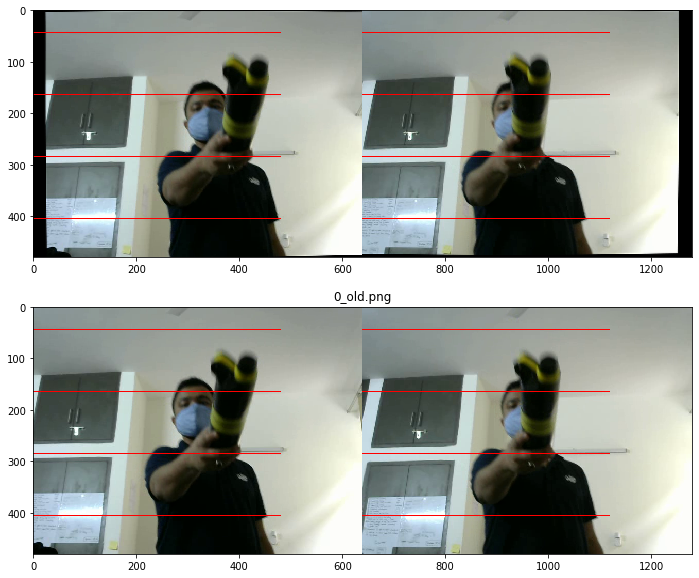

In [15]:

plt.rcParams["figure.figsize"] = (20,10)
images=glob.glob('results/*.png')
for i,fname in enumerate(images):
    name=fname.split('.')[0]
    if(len(name.split('_'))==1):  
        img_1=cv2.imread(fname)
        img_2=cv2.imread(name+'_old'+'.png')
        
        fig, ax = plt.subplots(2,1)
        
        ax[0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(name+'.png'))
        
        ax[1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(name+'_old'+'.png'))
        plt.show()
    break

## Quan sát 2 ảnh trên và cho biết sự khác biệt giữa cặp ảnh trước khi rectify và ảnh sua khi rectify?

# <h1><center> Disparity image</center></h1>

In [16]:
# So sánh disparity trước và sau khi rectification

In [21]:
number=1
imgL = cv2.imread("results_pair/"+str(number)+"_left_old.png",0)
imgL = cv2.resize(imgL,(600,600))
imgR = cv2.imread("results_pair/"+str(number)+"_right_old.png",0)
imgR = cv2.resize(imgR,(600,600))

imgL2 = cv2.imread("results_pair/"+str(number)+"_left_new.png",0)
imgL2 = cv2.resize(imgL2,(600,600))
imgR2 = cv2.imread("results_pair/"+str(number)+"_right_new.png",0)
imgR2 = cv2.resize(imgR2,(600,600))


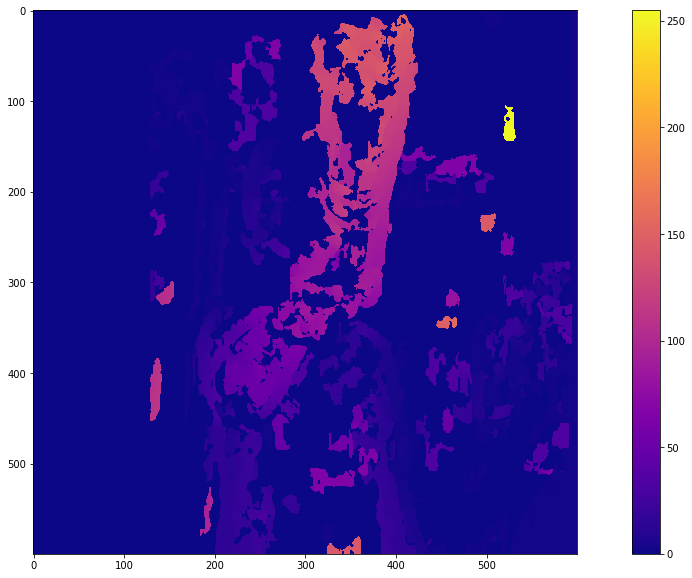

In [19]:
block_size = 11
min_disp = 0
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 10
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange
)

# Tính disparity cho ảnh trước khi rectify
disparity_SGBM = stereo.compute(imgL, imgR)

disparity_SGBM = cv2.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv2.NORM_MINMAX)
plt.imshow(disparity_SGBM,cmap='plasma')
plt.colorbar()
plt.show()

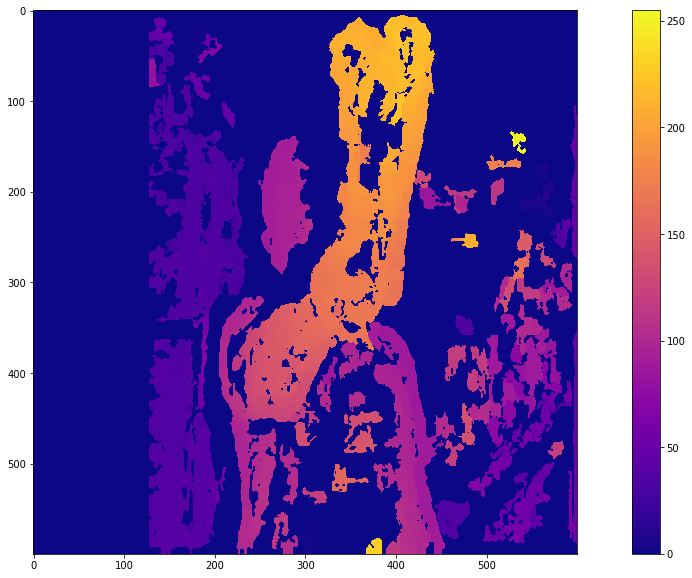

In [20]:
# Tính disparity cho ảnh sau khi rectify
####### YOUR CODE HERE ###################
....
plt.imshow(disparity_SGBM,cmap='plasma')
plt.colorbar()
plt.show()
##############################################

In [ ]:
# Lựa chọn các tham số khác nhau cho thuật toán StereoSGBM